<a id='data_section'></a>
# Data section

This section adds some informations about the datas used to train and test the model. It is important to know well the dataset if we want to explain the current model's behavior and improve it.

## Imports

In [19]:
import pandas as pd
import requests as rq
import numpy as np
import os
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, log_loss, roc_curve, fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt

## Data Loading

In [2]:
# Load training and test sets

df_train = pd.read_json('datas/training_set.json')
df_test = pd.read_json('datas/testing_set.json')

print(f"Train shape : {df_train.shape}")
print(f"Test shape : {df_test.shape}")

Train shape : (6035, 2)
Test shape : (1065, 2)


## Informations and visualisations of datasets

In [3]:
# Stats on the training set
df_train.describe()

,intent,sentence
count,6035,6035
unique,8,6035
top,irrelevant,Classique
freq,3852,1


### Comments
We see here there is indeed a total of 8 dfferent intents.
Moreover, the *irrelevant* intent in highly represented in the dataset (3852/6035).  

This can be good since *irrelevant* is the intent for every sentence that doesn't fit one of the 7 others. It is less specific than the others so it may need more examples to be well-recognized. Nevertheless, it can involve weak detections for the other intents by the model, because of a too small amount of examples.

In [4]:
# Informations about colums
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6035 entries, 0 to 6034
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    6035 non-null   object
 1   sentence  6035 non-null   object
dtypes: object(2)
memory usage: 94.4+ KB


### Comments
The dataset is made of 2 columns:
- `intent` is our target
- `sentence` is the input, it's what the user will give to the model

Both columns are categorical, we have no numerical value here.
In addition, there isn't any missing value (*non-null*).  
To finish, an important preprocessing part is needed before feeding a model with the datas since it is text (*i.e.* Tokenization, Word2Vec, ...).

In [5]:
# Show 10 first elements
df_train.head(n=10)

,intent,sentence
0,irrelevant,"850€ maximum pour le loyer, à partir de janvie..."
1,irrelevant,D'imprimer
2,purchase,Le meilleur cabriolet hybrid moins de 5m10 min...
3,find-hotel,en ce moment je cher un location pour les vaca...
4,irrelevant,c'est possible de t'utiliser la nuit ?
5,irrelevant,J'ai besoin d'acheter un fusil
6,irrelevant,Vous pouvez réserver pour 09h oui
7,irrelevant,Du 20 au 22 novembre pour 100-150 euros la nuit
8,purchase,Mon docteur m'a suggéré de porter des bandes p...
9,purchase,Commande à effectuer : 30 bloc note petits car...


### Comments
<p>This gives us some examples of rows in the dataset. We notice there are both short and long sentences, well-written or not, which is good to train the model on various writting styles (to work well on the different users' styles in production).</p>

In [6]:
# Show the 8 different intents rows counts
df_train["intent"].value_counts()

irrelevant           3852
purchase              613
find-restaurant       469
find-around-me        383
find-hotel            316
find-train            143
find-flight           142
provide-showtimes     117
Name: intent, dtype: int64

In [7]:
# Ratios (%) for each intent
total = df_train.shape[0]
round(df_train['intent'].value_counts() / total * 100 , 2)

irrelevant           63.83
purchase             10.16
find-restaurant       7.77
find-around-me        6.35
find-hotel            5.24
find-train            2.37
find-flight           2.35
provide-showtimes     1.94
Name: intent, dtype: float64

### Comments
We get here a more detailed count of rows for each intent. As we said before, there are mostly *irrelevant* rows (63%), the dataset is really unbalanced. There will be some analysis to make about the measures used to evaluate any model trained on this dataset.  

It's also unbalanced between the 7 'specific' intents. Maybe that's due to the use of the app made by the customers, asking more often for purchase matters than for showtimes ones.

# Model section

The only informations we have about the model are the measures given in the base project's README file. <br>
As the main problem is that we don't know how they were computed (which datas, cross-validation or not, etc..), we will try in the following cells to get our own measures on the datas we were given.

In [8]:
# Launch application to have access to the model
# Don't forget to pull image before doing anything else : docker pull wiidiiremi/projet_industrialisation_ia_3a
# This may take some time

# Change your custom port here
port = '8080'
os.system('docker run -p 8080:' + port + ' 3eec8ccf7aec &')

0

## About the model
The goal of the model is to find among the 8 intents which one fits the most to the user's request (*i.e.* sentence).
As a consequence, it is a **classification problem with 8 classes**.  
We can confirm the model is a classifier with the 8 probabilities he returns (*json* response) when given a sentence.  
However, we can't know what it is made of. It could be either a Neural Network or a Softmax Regression for example.

## Split datasets in inputs and labels

In [9]:
df_x_train = df_train['sentence']
df_y_train = df_train['intent']
df_x_test = df_test['sentence']
df_y_test = df_test['intent']

print(f"Train data shape : {df_x_train.shape}")
print(f"Train labels shape : {df_y_train.shape}")
print(f"Test data shape : {df_x_test.shape}")
print(f"Test labels shape : {df_y_test.shape}")

Train data shape : (6035,)
Train labels shape : (6035,)
Test data shape : (1065,)
Test labels shape : (1065,)


## Get model predictions for both datasets

In [10]:
route = 'http://localhost:' + port + '/api/intent?'

# Function to get the model's predictions for a given dataset
def predict(datas, threshold=None):
    
    # List of predicted intents
    predicted_labels = []
    # List of probabilities for the predicted intents
    prediction_probabilities = []
    
    # Request the model for each data
    for data in datas:
        
        try:
            res = rq.get(route, {'sentence':data}).json()
        except:
            print("Request Error: Service not available")
            return predicted_labels, prediction_probabilities 
        
        max_key = max(res, key=res.get)
        predicted_p = res[max_key]
        
        if threshold is not None:
            predicted_class = max_key if predicted_p >= threshold else 'irrelevant'
        else:
            predicted_class = max_key
            
        predicted_values = list(res.values())
 
        predicted_labels.append(predicted_class)
        prediction_probabilities.append(predicted_values)
        
    return predicted_labels, prediction_probabilities   

In [11]:
# Get both datasets predictions from the model
train_predicted_labels, train_predicted_probabilities = predict(df_x_train)
test_predicted_labels, test_predicted_probabilities = predict(df_x_test)

assert len(train_predicted_labels) == df_x_train.shape[0]
assert len(train_predicted_labels) == df_x_train.shape[0]
assert len(test_predicted_labels) == df_x_test.shape[0]
assert len(test_predicted_labels) == df_x_test.shape[0]

## Compute model's various scores

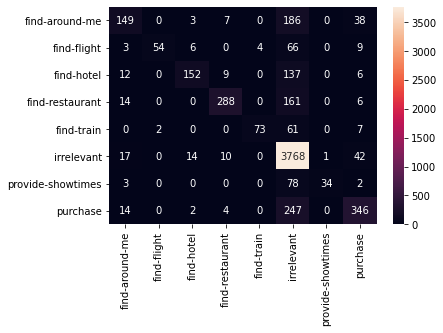

In [12]:
conf_matrix = confusion_matrix(df_y_train, train_predicted_labels)
labels = np.unique(df_train["intent"])
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

### Comments

Once again we notice in this confusion matrix that the dataset is very unbalanced. As the *irrelevant* class is much more represented in the dataset it is consequently much better predicted than the other classes. However, we see here that for each class except *irrelevant*, a large part of the samples have been wrongly predicted to be *irrelevant*, which is due to the over-representation of this class.

In [13]:
# Training scores
print(classification_report(df_y_train, train_predicted_labels))

                   precision    recall  f1-score   support

   find-around-me       0.70      0.39      0.50       383
      find-flight       0.96      0.38      0.55       142
       find-hotel       0.86      0.48      0.62       316
  find-restaurant       0.91      0.61      0.73       469
       find-train       0.95      0.51      0.66       143
       irrelevant       0.80      0.98      0.88      3852
provide-showtimes       0.97      0.29      0.45       117
         purchase       0.76      0.56      0.65       613

         accuracy                           0.81      6035
        macro avg       0.86      0.53      0.63      6035
     weighted avg       0.81      0.81      0.79      6035



In [14]:
# Test scores
print(classification_report(df_y_test, test_predicted_labels))

                   precision    recall  f1-score   support

   find-around-me       0.88      0.43      0.58        67
      find-flight       0.88      0.29      0.44        24
       find-hotel       0.78      0.38      0.51        55
  find-restaurant       0.98      0.56      0.71        93
       find-train       0.93      0.67      0.78        21
       irrelevant       0.79      0.98      0.87       677
provide-showtimes       0.80      0.29      0.42        14
         purchase       0.79      0.59      0.67       114

         accuracy                           0.80      1065
        macro avg       0.85      0.52      0.62      1065
     weighted avg       0.82      0.80      0.78      1065



In [15]:
# List of all intents in the same order as the model's output
intents = ["find-train", "irrelevant", "find-flight", "find-restaurant", "purchase", "find-around-me", "provide-showtimes", "find-hotel"]

# Function mapping a true label to a probabilities array 
def labelToProbs(label):
    
    assert label in intents
    
    # All probabilities are 0
    probs = np.zeros(8)
    
    for index, intent in enumerate(intents):
        if label == intent:
            # Set true label porbability to 1
            probs[index] = 1
            return probs
    

In [16]:
# ROC AUC scores

# Map True labels to probabilties arrays in order to compute ROC score
mapping = lambda x: labelToProbs(x)

y_true_train = list(map(mapping, df_y_train.to_numpy()))
y_true_test = list(map(mapping, df_y_test.to_numpy()))

train_roc = roc_auc_score(y_true_train, train_predicted_probabilities, multi_class='ovo')
test_roc = roc_auc_score(y_true_test, test_predicted_probabilities, multi_class='ovo')

print(f"Training ROC AUC : {round(train_roc,3)}")
print(f"Test ROC AUC : {round(test_roc, 3)}")

Training ROC AUC : 0.943
Test ROC AUC : 0.935


In [17]:
# Log loss
train_log_loss = log_loss(df_y_train, train_predicted_probabilities)
print(f"Training Log loss : {round(train_log_loss,3)}")

test_log_loss = log_loss(df_y_test, test_predicted_probabilities)
print(f"Test Log loss : {round(test_log_loss,3)}")

Training Log loss : 3.345
Test Log loss : 3.332


### Comments

The classification reports show an accuracy of **81%** for training (**80%** for test). We could say it is not that bad for a first model.
However, as we saw in the [Data Section](#data_section) our dataset is unbalanced (64:36 ratio between *irrelevant* class and the seven others). As a conclusion, we can't rate our model with its accuracy since it will tend to choose *irrelevant* to have the best accuracy ([see 'Accuracy Paradox'](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)). If this first model wasn't trained to get the best accuracy it is a good thing to have such an accuracy at the end, but we don't have any information about that.

## Our choice of metrics

First of all, we need a metric that is not influenced by unbalanced data as we said previously. For example something like Balanced Accuracy, which is already better in our case than Accuracy. 
Moreover, we can think about Precision an Recall since we have a classification problem, and even better a F-beta score to use both of them. 
As a reminder, the purpose of the model here is to help a human agent in his task by classifying the requests of the users before they get to him, and then offer the proper form if we are sure. The thing we want to avoid the most is classification errors, if the model is not sure about a request it should be transmitted to the human agent. That is why the model should be trained more on Precision than Recall since we want to avoid false positives (= classification errors).

That is why in the next steps, we will tend to train our model on Precision or F-beta score with beta < 1.

## About the dataset

Our dataset being unbalanced we have various options to train our model:
- Keep the same dataset
- Undersampling by removing rows of irrelevant intent
- Oversampling by replicating under represented intents' rows

The best solution in our opinion is to try each of those methods and then compare the resulting models to keep the best one.

# Thresholding

As explained above in our choice of metrics, the model should replace the human agent only when it is sure of the choice he made. This notion of being sure can be interpreted by a model with 100% accuracy. Then when it takes a decision it will be 100% sure about it. However it will no be the what we get in practice, our model won't have 100% precision, except if it overfits which is aother issue.

That is why to avoid taking wrong decisions and damaging user experience, we must define a threshold to have some notion of confidence when the model makes a choice. For example taking a 70% threshold would mean that any class with probability higher than 70% would be the prediction of the model. Otherwise, it would predict *irrelevant* since it is not confident enough, and the request will go to the human agent. It is an essantial value in the project, to avoid classification errors.

## Compute threshold

There are various methods to compute optimal threshold for a classification problem. For example, we can compute it from a ROC curve but also with a grid search algorithm.

Since we have a multiclass classification problem, it isn't a good idea to compute our threshold from a ROC curve. Indeed this methods mostly works for binary classification problems. We tried it by opposing each class to the seven others but we didn't get good results.

That is why we chose a grid search approach. The `predict()` method implemented above can take into account a threshold value, so we will use it with various values. To determine the best one, we will comapre the fbeta scores obtained for each threshold.

In [37]:
thresholds = np.linspace(0, 1, 50)
scores = []

for t in thresholds:
    
    labels, probs = predict(df_x_test, t)
    score = fbeta_score(df_y_test, labels, beta=0.5, average='weighted')
    scores.append(score)
    print(f"Got score {round(score,2)} for t = {round(t,2)}")
    
best_score = max(scores)
best_t = thresholds[scores.index(best_score)]
print(f"Best threshold found is {round(best_t,2)} with score {round(best_score,2)}")

Got score 0.79 for t = 0.0
Got score 0.79 for t = 0.02
Got score 0.79 for t = 0.04
Got score 0.79 for t = 0.06
Got score 0.79 for t = 0.08
Got score 0.79 for t = 0.1
Got score 0.79 for t = 0.12
Got score 0.79 for t = 0.14
Got score 0.79 for t = 0.16
Got score 0.79 for t = 0.18
Got score 0.79 for t = 0.2
Got score 0.79 for t = 0.22
Got score 0.79 for t = 0.24
Got score 0.79 for t = 0.27
Got score 0.79 for t = 0.29
Got score 0.79 for t = 0.31
Got score 0.79 for t = 0.33
Got score 0.79 for t = 0.35
Got score 0.78 for t = 0.37
Got score 0.77 for t = 0.39
Got score 0.76 for t = 0.41
Got score 0.76 for t = 0.43
Got score 0.75 for t = 0.45
Got score 0.74 for t = 0.47
Got score 0.73 for t = 0.49
Got score 0.73 for t = 0.51
Got score 0.72 for t = 0.53
Got score 0.72 for t = 0.55
Got score 0.71 for t = 0.57
Got score 0.69 for t = 0.59
Got score 0.67 for t = 0.61
Got score 0.66 for t = 0.63
Got score 0.66 for t = 0.65
Got score 0.64 for t = 0.67
Got score 0.63 for t = 0.69
Got score 0.61 for t = 

In [36]:
print(scores)

[0.7301344529157258, 0.7295040452408831, 0.7283701670794213, 0.727736102676301, 0.7278705339187171, 0.7267118275051055, 0.7228797042328573, 0.7217100671225302, 0.7218237084357085, 0.720674624643041, 0.720674624643041, 0.720674624643041, 0.7170116668133885, 0.7104472634564349, 0.7086988267156792, 0.7000296778496654, 0.6974784883114347, 0.6911329456961187, 0.6884979919689656, 0.6829633579079706, 0.680175192872177, 0.6759003476060144, 0.6755831659247498, 0.6724547645932704, 0.6710599114929748, 0.6678624787884945, 0.6632466767091141, 0.6598733757624782, 0.656448654371111, 0.656448654371111, 0.656448654371111, 0.6528622603959322, 0.6490969858592825, 0.6466306323304017, 0.6413315526206821, 0.6380626872736789, 0.6362783949587213, 0.633882414394993, 0.6312474800400206, 0.6209993431870072, 0.6190915667186015, 0.6130957456407627, 0.6075900874264, 0.6055135624514371, 0.6033469313757445, 0.5980365300900568, 0.5980365300900568, 0.5885703531548826, 0.5885703531548826, 0.5821715440851583, 0.582171544